In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost import plot_importance
from sklearn.multioutput import MultiOutputRegressor
import shap
import warnings
warnings.filterwarnings('ignore')
# ## 1. Data Loading and Exploration

# Load the dataset
df = pd.read_csv("C:\\Users\\speak\\Downloads\\food wastage data (1).csv")

# Display basic information
print(f"Dataset Shape: {df.shape}")
print("\nSample Data:")
display(df.head())

# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
display(df.describe())


Dataset Shape: (214, 12)

Sample Data:


,Country,combined figures (kg/capita/year),Household estimate (kg/capita/year),Household estimate (tonnes/year),Retail estimate (kg/capita/year),Retail estimate (tonnes/year),Food service estimate (kg/capita/year),Food service estimate (tonnes/year),Confidence in estimate,M49 code,Region,Source
0,Afghanistan,126,82,3109153,16,594982,28,1051783,Very Low Confidence,4,Southern Asia,https://www.unep.org/resources/report/unep-foo...
1,Albania,127,83,238492,16,45058,28,79651,Very Low Confidence,8,Southern Europe,https://www.unep.org/resources/report/unep-foo...
2,Algeria,135,91,3918529,16,673360,28,1190335,Very Low Confidence,12,Northern Africa,https://www.unep.org/resources/report/unep-foo...
3,Andorra,123,84,6497,13,988,26,1971,Low Confidence,20,Southern Europe,https://www.unep.org/resources/report/unep-foo...
4,Angola,144,100,3169523,16,497755,28,879908,Very Low Confidence,24,Sub-Saharan Africa,https://www.unep.org/resources/report/unep-foo...



Missing Values:


Country                                   0
combined figures (kg/capita/year)         0
Household estimate (kg/capita/year)       0
Household estimate (tonnes/year)          0
Retail estimate (kg/capita/year)          0
Retail estimate (tonnes/year)             0
Food service estimate (kg/capita/year)    0
Food service estimate (tonnes/year)       0
Confidence in estimate                    0
M49 code                                  0
Region                                    0
Source                                    0
dtype: int64


Summary Statistics:


,combined figures (kg/capita/year),Household estimate (kg/capita/year),Household estimate (tonnes/year),Retail estimate (kg/capita/year),Retail estimate (tonnes/year),Food service estimate (kg/capita/year),Food service estimate (tonnes/year),M49 code
count,214.000000,214.000000,2.140000e+02,214.000000,2.140000e+02,214.000000,2.140000e+02,214.000000
mean,126.794393,84.294393,2.658896e+06,15.116822,5.520454e+05,27.383178,1.138859e+06,433.971963
std,22.157879,18.313705,8.596906e+06,5.767840,2.195578e+06,6.508420,5.380459e+06,252.185786
min,61.000000,33.000000,8.500000e+02,3.000000,1.380000e+02,3.000000,2.760000e+02,4.000000
25%,115.000000,74.000000,6.831550e+04,13.000000,1.250925e+04,26.000000,2.239125e+04,219.000000
50%,123.000000,80.000000,5.205080e+05,16.000000,1.006500e+05,28.000000,1.884660e+05,432.000000
75%,137.750000,95.000000,2.111314e+06,16.000000,3.568158e+05,28.000000,6.307618e+05,645.250000
max,260.000000,189.000000,9.164621e+07,79.000000,2.242470e+07,90.000000,6.537774e+07,894.000000


In [5]:
# ## 2. Feature Engineering and Data Preparation

# Function to generate temporal features for future prediction
def create_temporal_features(base_df, start_year=2025, years=5):
    """Generate temporal features for future predictions"""
    future_df = pd.DataFrame()
    
    for year_offset in range(years):
        year = start_year + year_offset
        temp_df = base_df.copy()
        
        # Add temporal features
        temp_df['Year'] = year
        temp_df['Population_Growth'] = 1.01 + (0.005 * year_offset)  # Simulated annual growth
        temp_df['GDP_Growth'] = 2.5 + (0.2 * year_offset)  # Simulated GDP growth
        temp_df['Urbanization_Rate'] = np.clip(
            base_df['Urbanization_Rate'] + (0.01 * year_offset) if 'Urbanization_Rate' in base_df.columns 
            else np.random.uniform(0.5, 0.8, len(base_df)),
            0, 1
        )
        temp_df['Temperature'] = 15 + (0.2 * year_offset) + np.random.normal(0, 1, len(base_df))
        
        future_df = pd.concat([future_df, temp_df])
    
    return future_df

# Specify features and targets
features = ['Region', 'Confidence in estimate', 'Year', 
           'Population_Growth', 'GDP_Growth',
           'Urbanization_Rate', 'Temperature']

targets = ['Household estimate (kg/capita/year)', 
          'Retail estimate (kg/capita/year)',
          'Food service estimate (kg/capita/year)']

# Simplified target names for plotting
target_names = ['Household', 'Retail', 'Food Service']

# Create temporal features
full_df = create_temporal_features(df)

# %% [code]
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year', 'Population_Growth', 
                                  'GDP_Growth', 'Urbanization_Rate',
                                  'Temperature']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Region', 'Confidence in estimate'])
    ])

# Process features
X = preprocessor.fit_transform(full_df[features])
y = full_df[targets]

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# ## 3. XGBoost Model Training

# Set up XGBoost parameters
base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method='hist',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1
)

# Create multi-output model
model = MultiOutputRegressor(base_model)

# Train the model
model.fit(X_train, y_train)



MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None, ...))

,MSE (Test),RMSE (Test),R² (Test),MSE (Train),RMSE (Train),R² (Train)
Household,185.446861,13.617888,0.408928,4.140017,2.034703,0.987769
Retail,12.567420,3.545056,0.590358,0.000768,0.027706,0.999977
Food Service,14.353661,3.788623,0.595715,0.041529,0.203787,0.999052


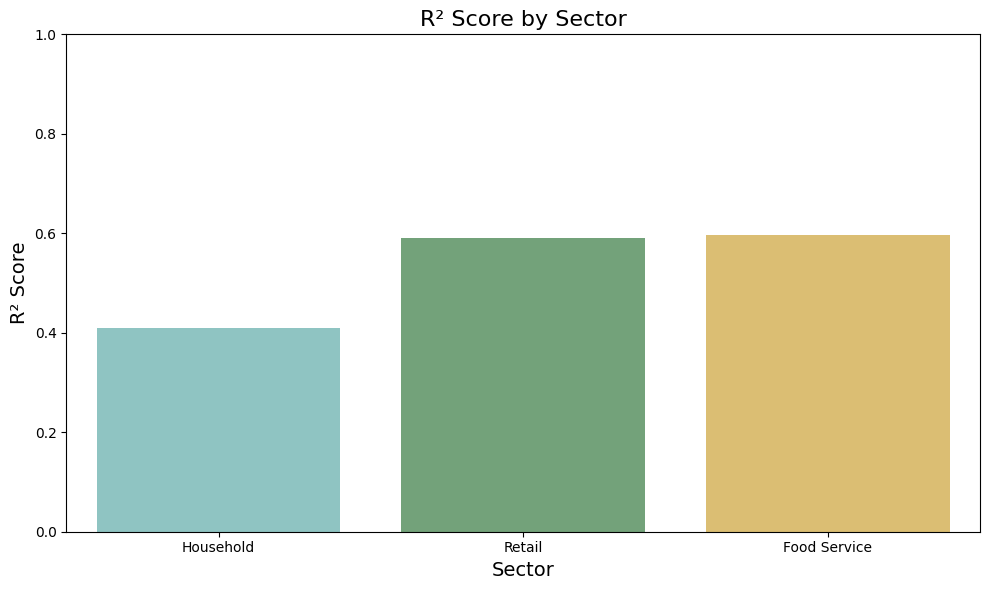

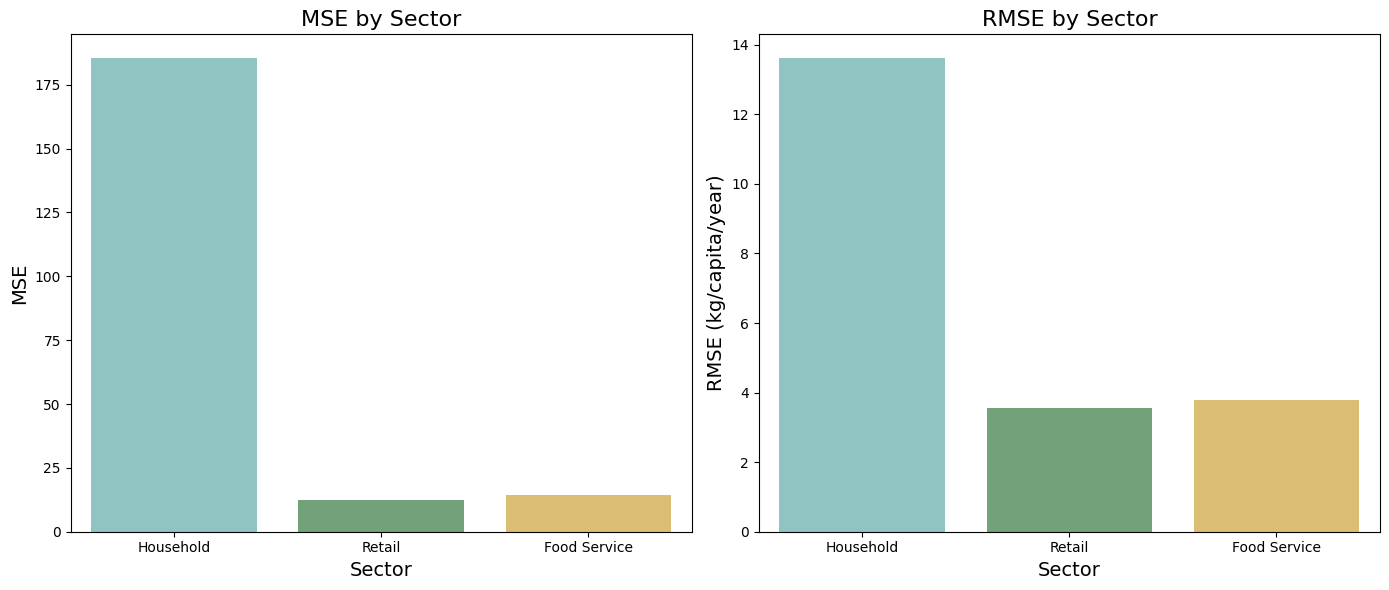

In [7]:

# ## 4. Model Evaluation

# Generate predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics
metrics = {}
for i, target in enumerate(targets):
    train_mse = mean_squared_error(y_train.iloc[:,i], y_pred_train[:,i])
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train.iloc[:,i], y_pred_train[:,i])
    
    test_mse = mean_squared_error(y_test.iloc[:,i], y_pred_test[:,i])
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test.iloc[:,i], y_pred_test[:,i])
    
    metrics[target_names[i]] = {
        'MSE (Test)': test_mse,
        'RMSE (Test)': test_rmse,
        'R² (Test)': test_r2,
        'MSE (Train)': train_mse,
        'RMSE (Train)': train_rmse,
        'R² (Train)': train_r2
    }

# Display metrics
metrics_df = pd.DataFrame(metrics).T
display(metrics_df)

# Visualize R² scores by sector
plt.figure(figsize=(10, 6))
sns.barplot(
    x=metrics_df.index, 
    y=metrics_df['R² (Test)'],
    palette=['#86CDCA', '#6BAA75', '#ECC662']
)
plt.title('R² Score by Sector', fontsize=16)
plt.ylabel('R² Score', fontsize=14)
plt.xlabel('Sector', fontsize=14)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('r2_score_by_sector.png', dpi=300, bbox_inches='tight')
plt.show()

# MSE and RMSE comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(
    x=metrics_df.index, 
    y=metrics_df['MSE (Test)'],
    palette=['#86CDCA', '#6BAA75', '#ECC662'],
    ax=ax[0]
)
ax[0].set_title('MSE by Sector', fontsize=16)
ax[0].set_ylabel('MSE', fontsize=14)
ax[0].set_xlabel('Sector', fontsize=14)

sns.barplot(
    x=metrics_df.index, 
    y=metrics_df['RMSE (Test)'],
    palette=['#86CDCA', '#6BAA75', '#ECC662'],
    ax=ax[1]
)
ax[1].set_title('RMSE by Sector', fontsize=16)
ax[1].set_ylabel('RMSE (kg/capita/year)', fontsize=14)
ax[1].set_xlabel('Sector', fontsize=14)
plt.tight_layout()
plt.savefig('error_metrics_by_sector.png', dpi=300, bbox_inches='tight')
plt.show()



,Year,Household,Retail,Food Service
0,2025,84.743240,15.170720,27.225246
1,2026,85.535545,15.161262,27.094448
2,2027,84.622307,14.991924,27.219982
3,2028,84.287323,15.109918,26.952715
4,2029,83.903610,14.985689,27.550539
5,2030,84.369995,15.090907,27.599016


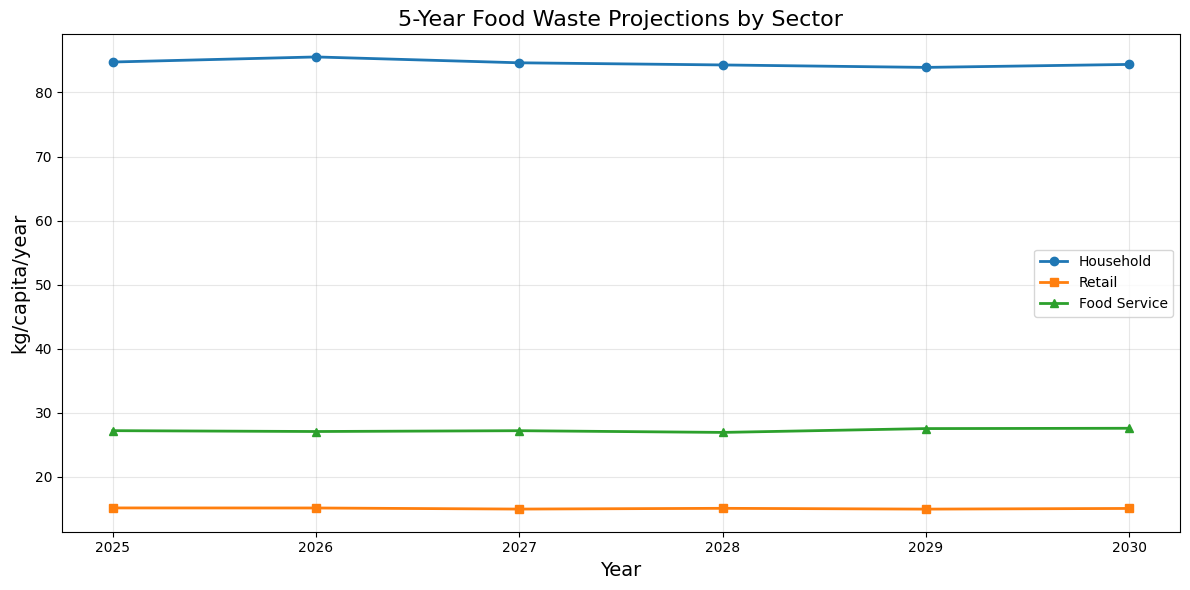

Average Annual Growth Rates:
Household: -0.09%
Retail: -0.10%
Food Service: 0.28%


In [8]:
# ## 5. Future Predictions

# Generate future predictions (2025-2030)
future_df = create_temporal_features(df, start_year=2025, years=6)
X_future = preprocessor.transform(future_df[features])
future_preds = model.predict(X_future)

# Create prediction dataframe
future_results = future_df[['Country', 'Region', 'Year']].copy()
for i, target in enumerate(target_names):
    future_results[target] = future_preds[:,i]

# Group by year to get average projections
year_projections = future_results.groupby('Year')[target_names].mean().reset_index()
display(year_projections)

# Plot 5-year projections
plt.figure(figsize=(12, 6))
plt.plot(year_projections['Year'], year_projections['Household'], 
         marker='o', linewidth=2, label='Household')
plt.plot(year_projections['Year'], year_projections['Retail'], 
         marker='s', linewidth=2, label='Retail')
plt.plot(year_projections['Year'], year_projections['Food Service'], 
         marker='^', linewidth=2, label='Food Service')

plt.title('5-Year Food Waste Projections by Sector', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('kg/capita/year', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('waste_projections_by_sector.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate growth rates
growth_df = year_projections.copy()
growth_df.set_index('Year', inplace=True)
growth_rates = growth_df.pct_change().mean() * 100

print("Average Annual Growth Rates:")
for sector, rate in growth_rates.items():
    print(f"{sector}: {rate:.2f}%")


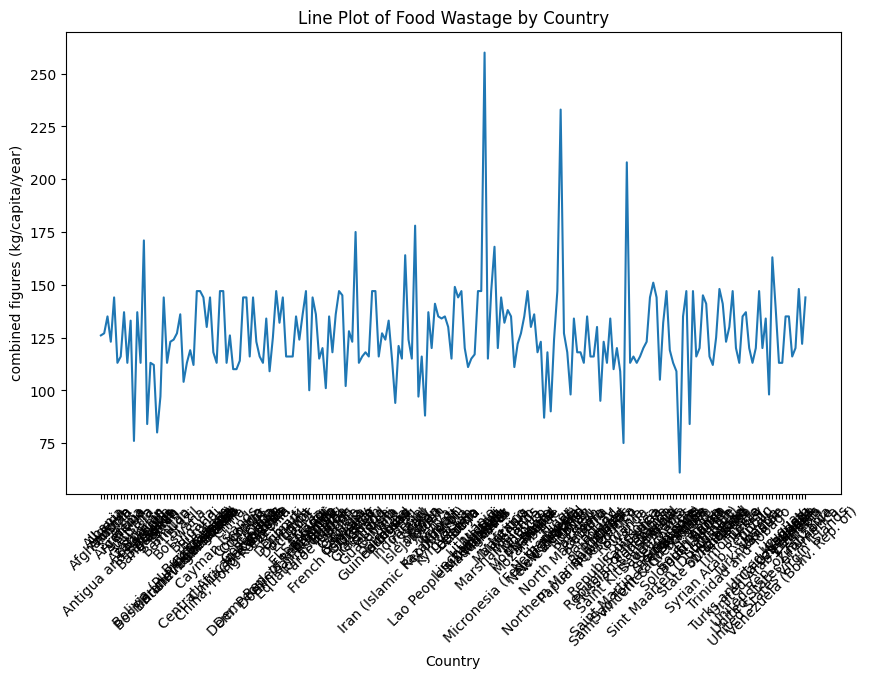

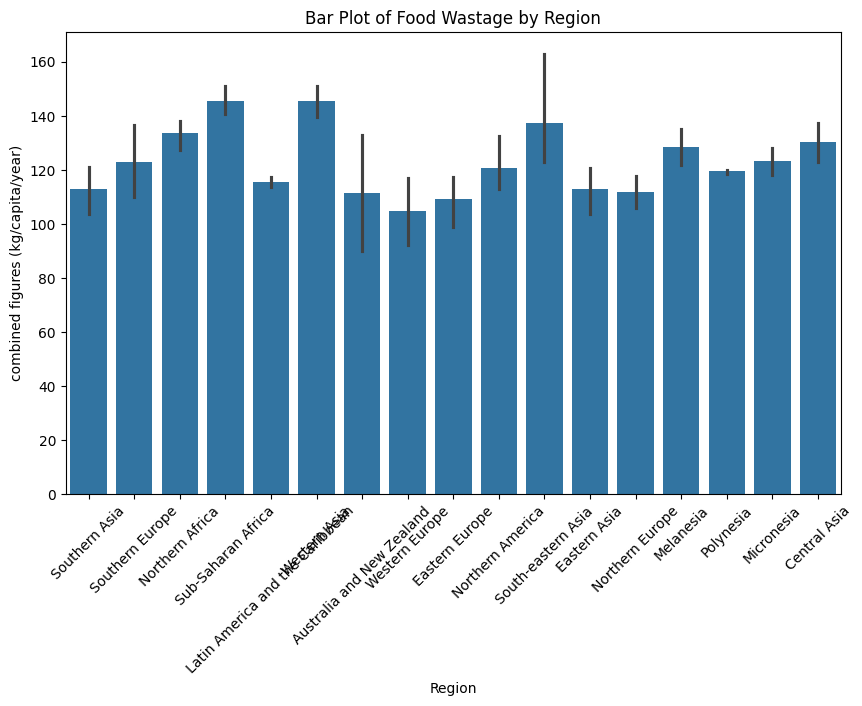

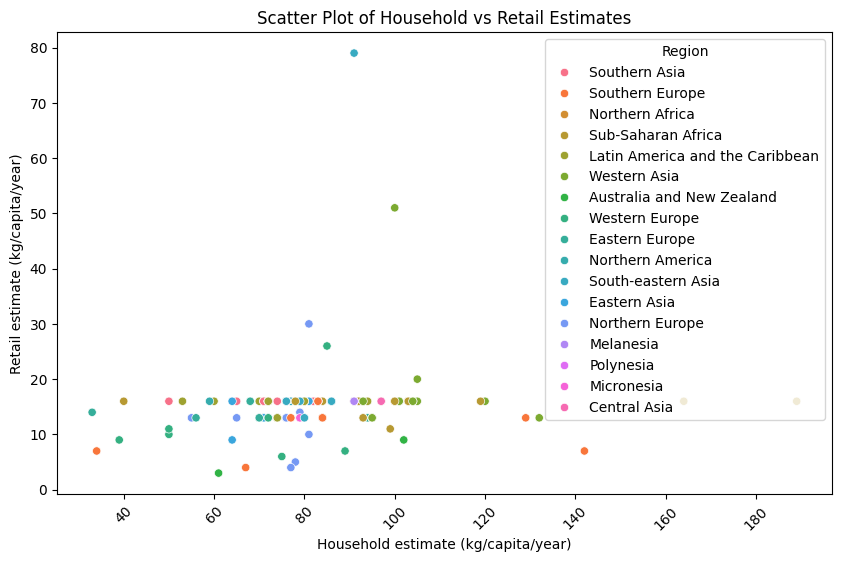

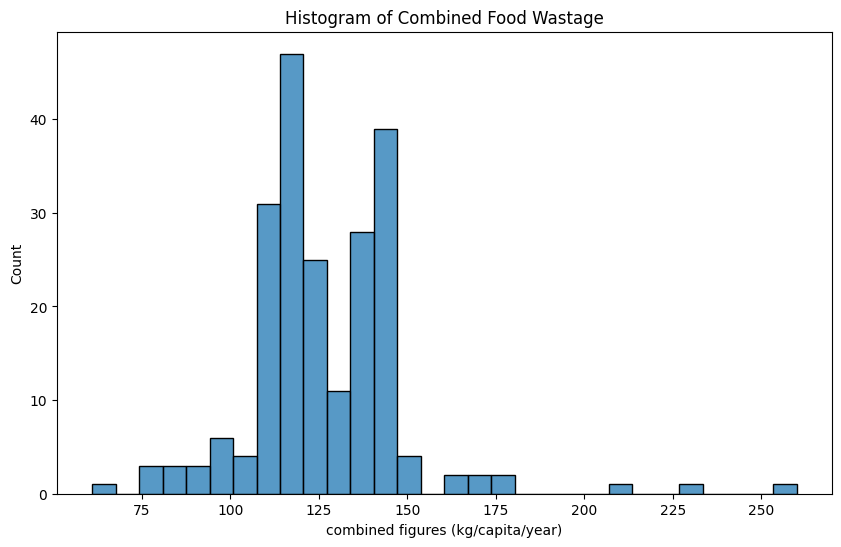

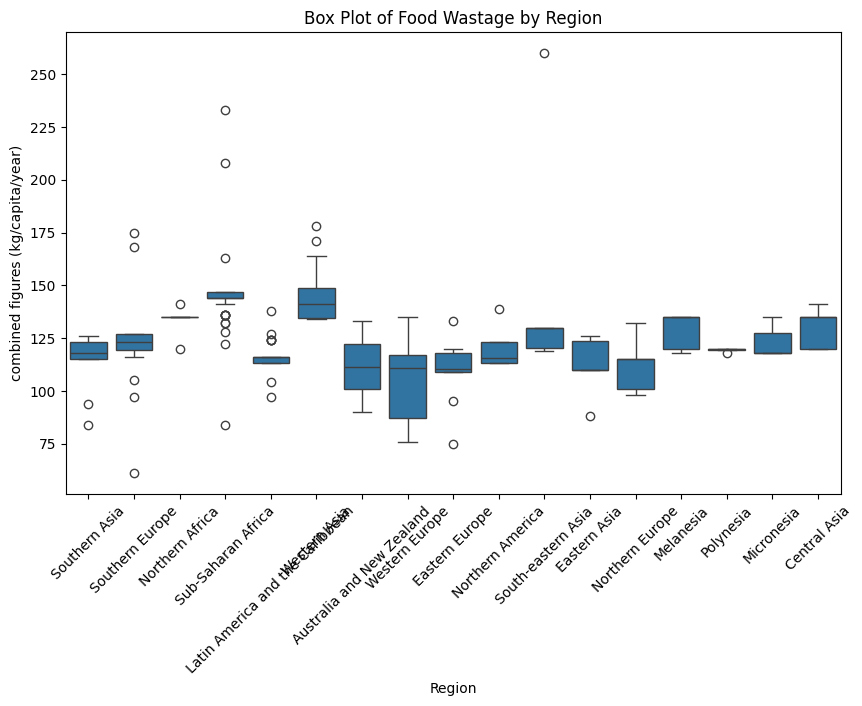

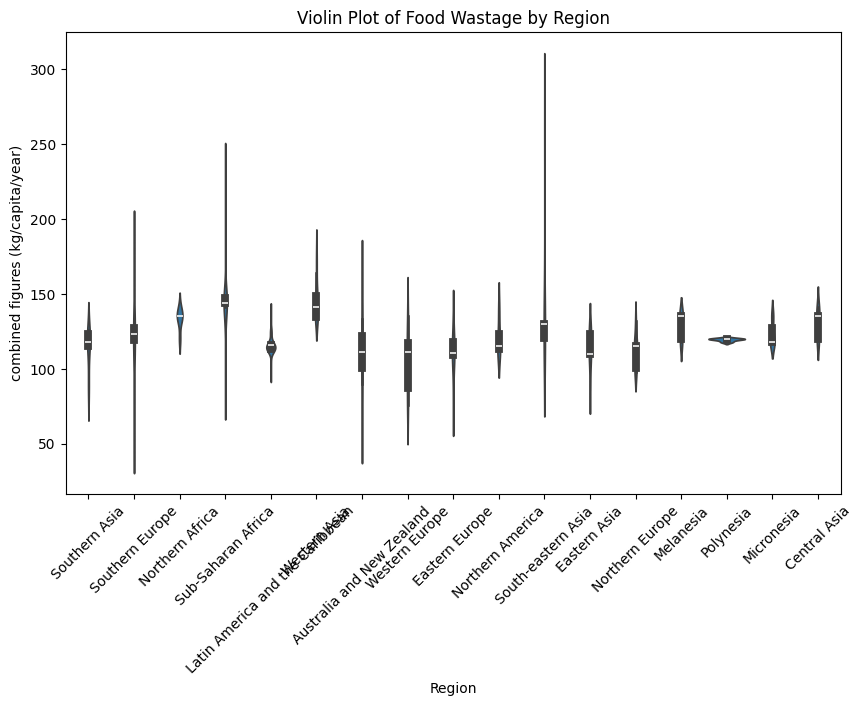

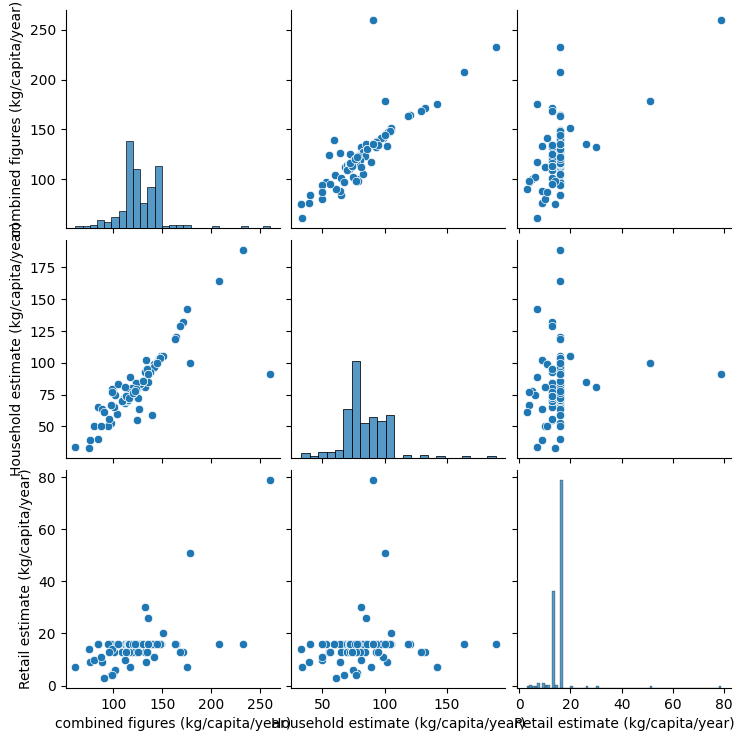

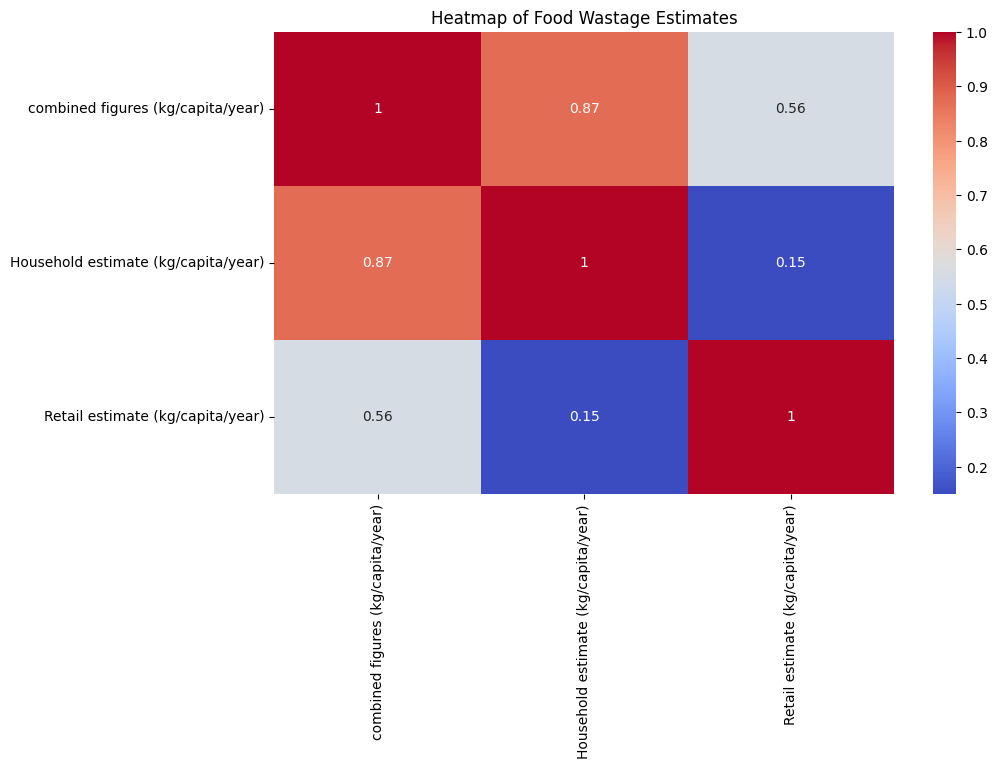

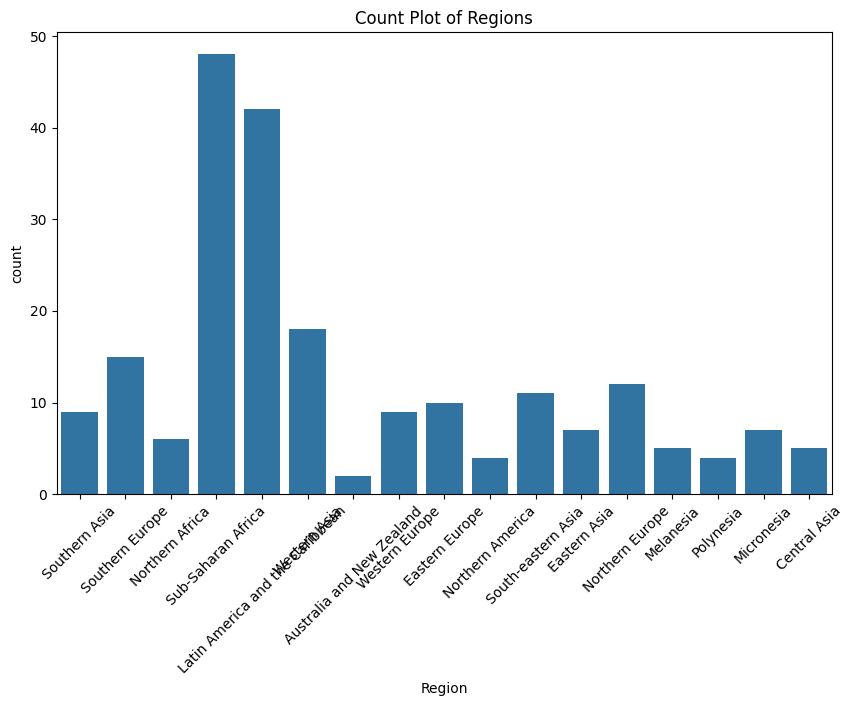

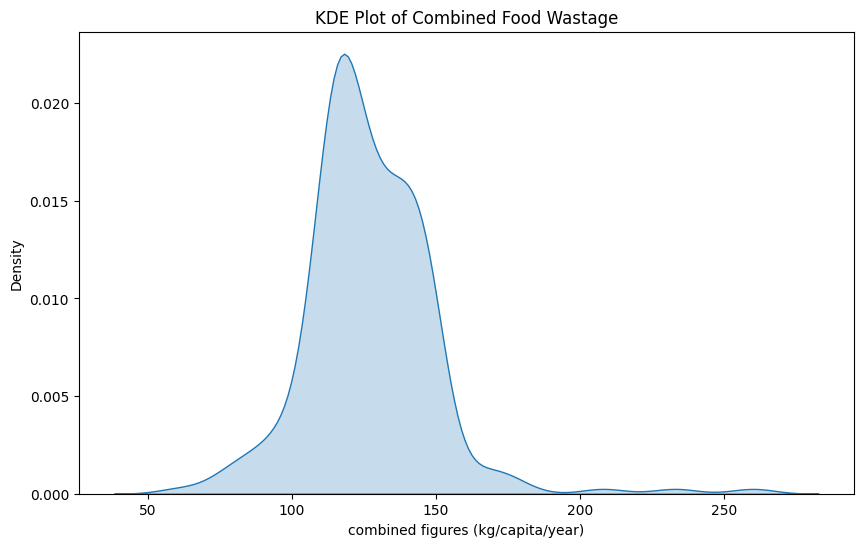

       combined figures (kg/capita/year)  Household estimate (kg/capita/year)  \
count                         214.000000                           214.000000   
mean                          126.794393                            84.294393   
std                            22.157879                            18.313705   
min                            61.000000                            33.000000   
25%                           115.000000                            74.000000   
50%                           123.000000                            80.000000   
75%                           137.750000                            95.000000   
max                           260.000000                           189.000000   

       Retail estimate (kg/capita/year)  
count                        214.000000  
mean                          15.116822  
std                            5.767840  
min                            3.000000  
25%                           13.000000  
50%               

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
data = pd.read_csv("C:\\Users\\speak\\Downloads\\food wastage data.csv")

# Visualization Graphs
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Country', y='combined figures (kg/capita/year)')  
plt.title('Line Plot of Food Wastage by Country')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Region', y='combined figures (kg/capita/year)')
plt.title('Bar Plot of Food Wastage by Region')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Household estimate (kg/capita/year)', y='Retail estimate (kg/capita/year)', hue='Region')
plt.title('Scatter Plot of Household vs Retail Estimates')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['combined figures (kg/capita/year)'].dropna(), bins=30)
plt.title('Histogram of Combined Food Wastage')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Region', y='combined figures (kg/capita/year)')
plt.title('Box Plot of Food Wastage by Region')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='Region', y='combined figures (kg/capita/year)')
plt.title('Violin Plot of Food Wastage by Region')
plt.xticks(rotation=45)
plt.show()

sns.pairplot(data[['combined figures (kg/capita/year)', 'Household estimate (kg/capita/year)', 'Retail estimate (kg/capita/year)']].dropna())
plt.show()

plt.figure(figsize=(10, 6))
# Convert estimates to numeric, handling errors
data['Household estimate (kg/capita/year)'] = pd.to_numeric(data['Household estimate (kg/capita/year)'], errors='coerce')
data['Retail estimate (kg/capita/year)'] = pd.to_numeric(data['Retail estimate (kg/capita/year)'], errors='coerce')
sns.heatmap(data[['combined figures (kg/capita/year)', 'Household estimate (kg/capita/year)', 'Retail estimate (kg/capita/year)']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Food Wastage Estimates')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Region')
plt.title('Count Plot of Regions')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data['combined figures (kg/capita/year)'].dropna(), fill=True)
plt.title('KDE Plot of Combined Food Wastage')
plt.show()

# Non-Visualization Tables
summary_table = data[['combined figures (kg/capita/year)', 'Household estimate (kg/capita/year)', 'Retail estimate (kg/capita/year)']].describe()
print(summary_table)

correlation_table = data[['combined figures (kg/capita/year)', 'Household estimate (kg/capita/year)', 'Retail estimate (kg/capita/year)']].corr()
print(correlation_table)

value_counts_table = data['Region'].value_counts()
print(value_counts_table)

grouped_table = data.groupby('Region').mean(numeric_only=True)
print(grouped_table)

median_table = data[['combined figures (kg/capita/year)', 'Household estimate (kg/capita/year)', 'Retail estimate (kg/capita/year)']].median()
print(median_table)

std_dev_table = data[['combined figures (kg/capita/year)', 'Household estimate (kg/capita/year)', 'Retail estimate (kg/capita/year)']].std()
print(std_dev_table)

min_max_table = data[['combined figures (kg/capita/year)']].agg(['min', 'max'])
print(min_max_table)

quantile_table = data[['combined figures (kg/capita/year)', 'Household estimate (kg/capita/year)', 'Retail estimate (kg/capita/year)']].quantile([0.25, 0.5, 0.75])
print(quantile_table)

unique_values_table = data.nunique()
print(unique_values_table)

missing_values_table = data.isnull().sum()
print(missing_values_table)

Mean Squared Error: 26.46043475489354
R^2 Score: 0.9390409797957645


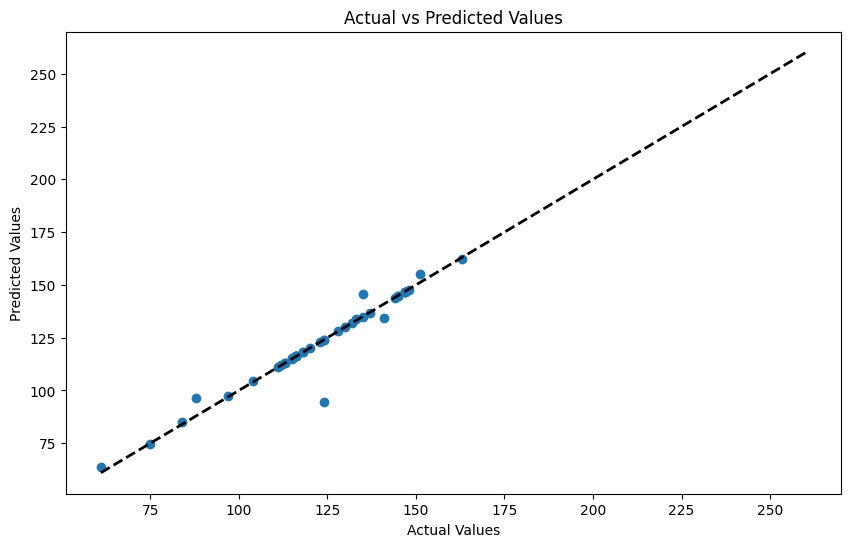

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset
data = pd.read_csv("C:\\Users\\speak\\Downloads\\food wastage data.csv")

# Convert estimates to numeric, handling errors
data['Household estimate (kg/capita/year)'] = pd.to_numeric(data['Household estimate (kg/capita/year)'], errors='coerce')
data['Retail estimate (kg/capita/year)'] = pd.to_numeric(data['Retail estimate (kg/capita/year)'], errors='coerce')

# Drop rows with missing values in the relevant columns
data = data.dropna(subset=['combined figures (kg/capita/year)', 
                            'Household estimate (kg/capita/year)', 
                            'Retail estimate (kg/capita/year)'])

# Define features and target variable
X = data[['Household estimate (kg/capita/year)', 'Retail estimate (kg/capita/year)']]
y = data['combined figures (kg/capita/year)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()